#### Acceptance Sampling

Okay, making a notebook that does the rejection sampling in a way that makes sense. Follow the link at https://towardsdatascience.com/what-is-rejection-sampling-1f6aff92330d.

Suppose we have a function from which we need to draw random samples from (also called target distribution), but we cannot do this straight forwardly. Suppose function is 

${f(x)} = {e^{-x^2/2} . (sin^2(6+x) + 3.cos^2(x).sin^2(4x) + 1)}$, and we need to draw samples from this. This function looks like a bimodal one (refer the link). Suppose we chose a proposal (envelope) distribution from uniform (-3,3). This function does not cover the target distribtution, therefore we need to scale it up (by a factor of about 25 (M or C as defined by different authors)) to cover the target distribution.

$x \sim uni(-3,3)$

$g(x) = \frac{1}{b-a}$

and therefore $Mg(x) = 25g(x)$

Step 1: First we sample from our proposal distribution, that is we sample from $g(x)$. Suppose this value is $x$, we can evaluate both $f(x)$ and $Mg(X)$ at this $x$. (And one way to get $M$ is to get the maximum of ration $\frac{f(x)}{g(x)}$, $x$ being from the support considered. And this $M >= \frac{f(x)}{g(x)}$). Also, note that the $g(x)$ can be any known pdf.

Step 2: Then we sample from $u \sim uni(0,Mg(x))$

Step 3: Now if this $u <= f(x)$ ($x$ coming from $g(x)$ and $f(x)$ evaluated at this $x$), we accept, else we reject. There is also an alternative formulation of the acceptance criteria. That is draw $u \sim uni(0,1)$ and the acceptance criteria in here would be accept if $u <= \frac{f(x)}{M.g(x)}$ .

Let's implement this

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, uniform
import random

In [2]:
# define the target distribution just for visualization purposes
def tilde_p(x):
    return (np.exp(-x**2 / 2) *
            (np.sin(6 * x)**2 + 3 * np.cos(x)**2 * np.sin(4 * x)**2 + 1))

In [3]:
xrange = np.linspace(-4, 4, 500)
xrange.shape

(500,)

In [4]:
def plot_target_and_approx(k, q, loc, scale):
    fig, ax = plt.subplots(1)
    sns.despine(fig)
    sns.lineplot(x=xrange, y=tilde_p(xrange), ax=ax)
    sns.lineplot(x=xrange, y=k * q.pdf(xrange, loc, scale), ax=ax)
    return fig, ax

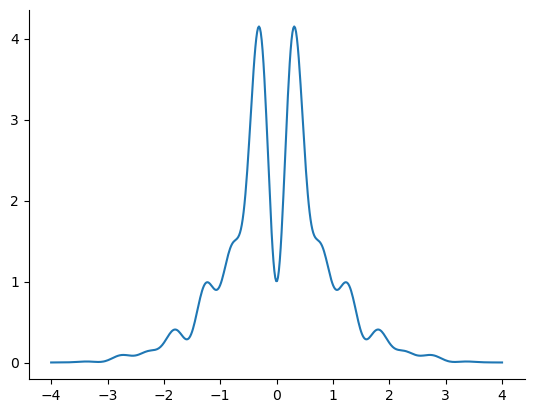

In [5]:
# Just the target curve
fig, ax = plt.subplots(1)
sns.despine(fig)
sns.lineplot(x=xrange, y=tilde_p(xrange), ax=ax)
plt.show()

In [6]:
# Construct and plot the uniform proposal distribution
q_uniform = uniform.pdf(xrange, loc=-3, scale=6)

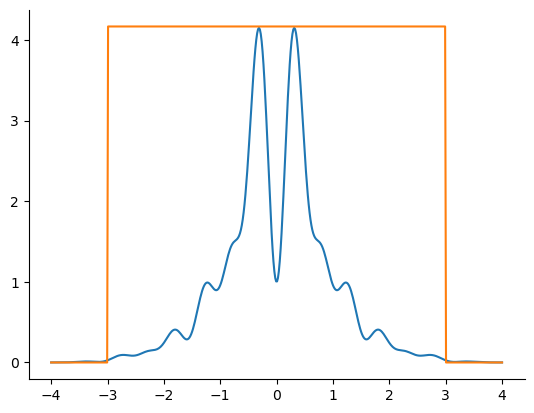

In [7]:
fig, ax = plt.subplots(1)
sns.despine(fig)
sns.lineplot(x=xrange, y=tilde_p(xrange), ax=ax)
sns.lineplot(x=xrange, y=25 * q_uniform, ax=ax)
plt.show()

Now let's do the acceptance sampling - with a uniform distribution as the proposal distribution

In [8]:
# Step 1
# First sample from proposal function g(x) which is uniform(-3,3) - Let's sample 100000 values - increasing N leads to better results

N = 100000
X = np.random.uniform(-3,3, size=N)

In [9]:
# X

In [10]:
# Proposal function can be written in a function form as below
prop_uni = uniform(-3, 6)

In [11]:
# Evaluate f(x) at these X's generated randomly from the proposal distribution
f_at_X = tilde_p(X)

# Evaluate Mg(x) at this X
M = 25
M_g_at_X = M*prop_uni.pdf(X)

In [12]:
# f_at_X

In [13]:
# M_g_at_X

In [14]:
# Step 2
# draw u from uniform distribution
u = np.random.uniform(0, M_g_at_X)

In [15]:
# Step 3: Now if $u <= f(x)$, accept that X as from being sampled from the target function
Accepted_samples = X[u < f_at_X]

In [16]:
# proportion of accepted samples
len(Accepted_samples)/N

0.2315

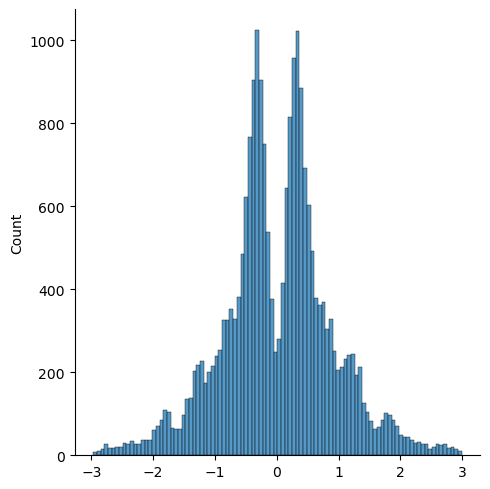

In [17]:
sns.displot(Accepted_samples, bins = 100)
plt.show()

Note that this proposal distribution ends up rejecting a lot of samples drawn from $g(x)$, let's use a better proposal distribution - Normal distribution

In [18]:
# Construct and plot the normal proposal distribution
q_norm = norm.pdf(xrange, loc=0, scale=1)

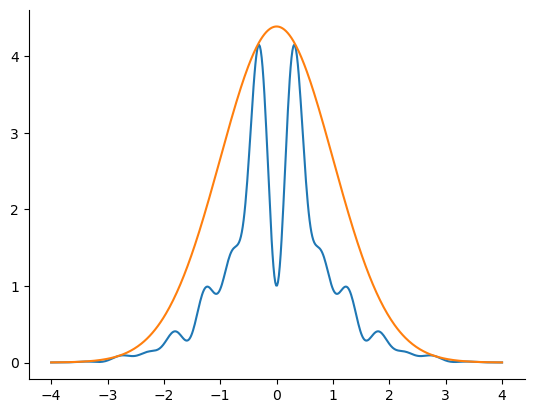

In [19]:
fig, ax = plt.subplots(1)
sns.despine(fig)
sns.lineplot(x=xrange, y=tilde_p(xrange), ax=ax)
sns.lineplot(x=xrange, y=11 * q_norm, ax=ax)
plt.show()

Now let's do the acceptance sampling - with a normal distribution as the proposal distribution

In [20]:
# Step 1
# First sample from proposal function g(x) Let's sample 100000 values - increasing N leads to better results

N = 100000
X_norm = np.random.normal(0,1, size=N)

In [21]:
# X

In [22]:
# Proposal function can be written in a function form as below
prop_norm = norm(loc = 0,scale =  1)

In [23]:
# Evaluate f(x) at these X's generated randomly from the proposal distribution
f_at_X_norm = tilde_p(X_norm)

# Evaluate Mg(x) at this X
M = 11
M_g_at_X_norm = M*prop_norm.pdf(X_norm)

In [24]:
# f_at_X_norm

In [25]:
# M_g_at_X_norm

In [26]:
# Step 2
# draw u from uniform distribution
u_for_norm = np.random.uniform(0, M_g_at_X_norm)

In [27]:
# Step 3: Now if $u <= f(x)$, accept that X as from being sampled from the target function
Accepted_samples_for_norm = X_norm[u_for_norm < f_at_X_norm]

In [28]:
# proportion of accepted samples
len(Accepted_samples_for_norm)/N

0.53495

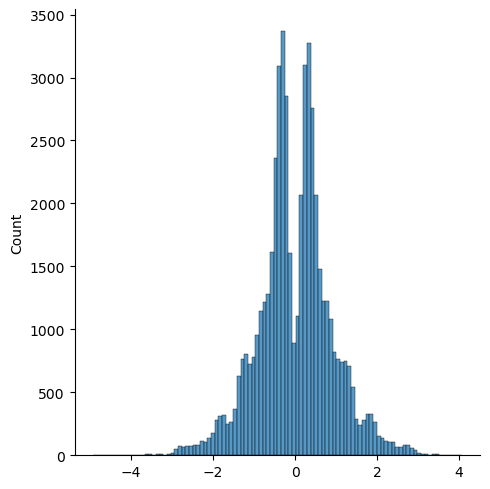

In [29]:
sns.displot(Accepted_samples_for_norm, bins = 100)
plt.show()

Below is another rejection sampling code, doing something very similar

In [30]:
def rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, n_samples):
    """
    Perform rejection sampling to generate samples from the target distribution.

    Args:
        target_pdf: The probability density function of the target distribution.
        proposal_pdf: The probability density function of the proposal distribution.
        proposal_sampler: A function to generate samples from the proposal distribution.
        n_samples: The number of samples to generate.

    Returns:
        A list of samples from the target distribution.
    """

    samples = []
    # Find the maximum ratio of the target pdf to the proposal pdf
    x_range = np.arange(0, 10, 0.01)
    max_ratio = max(target_pdf(x) / proposal_pdf(x) for x in x_range)

    while len(samples) < n_samples:
        x = proposal_sampler()
        u = np.random.uniform(0, max_ratio * proposal_pdf(x))
        if u <= target_pdf(x):
            samples.append(x)

    return samples

In [31]:
# Example usage:
def target_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # Standard normal distribution


In [32]:
def proposal_pdf(x):
    return 0.5 * np.exp(-abs(x))  # Laplace distribution

In [33]:
def proposal_sampler():
    return np.random.laplace(0, 1)

In [34]:
x_range = np.arange(0, 10, 0.01)
max_ratio = max(target_pdf(x) / proposal_pdf(x) for x in x_range)

In [35]:
max_ratio

1.3154892469589137

In [36]:
samples = rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, 1000)

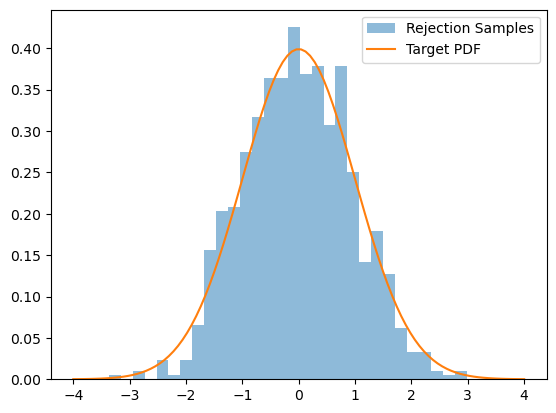

In [37]:
plt.hist(samples, bins=30, density=True, alpha=0.5, label="Rejection Samples")
x = np.linspace(-4, 4, 100)
plt.plot(x, target_pdf(x), label="Target PDF")
plt.legend()
plt.show()

In [38]:
len(samples)

1000